In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

Establishing, the for loop to run through the frames.

In [3]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 152, 153, 155, 156, 166, 167, 168, 171, 198]


In [15]:
# function to get the file path, according to the label, up_down and video_index
def get_file_path(label, up_down, video_index):

    if label == 'correct':
        image_dir = 'images/correct_seq'
        corr_inc = 'cor'
    elif label == 'incorrect':
        image_dir = 'images/wrong_seq'
        corr_inc = 'inc'
    else:
        print('Label not found')
        exit()

    # Constructing the file pattern using the video index
    file_pattern = f'{corr_inc}_{up_down}_{video_index}_*.jpg'
    file_pattern_path = os.path.join(image_dir, file_pattern)
    # Finding the file that matches the pattern
    matching_files = glob.glob(file_pattern_path)
    # In case there is more than one
    if len(matching_files) > 1:
        print('More than one file found')
        exit()
    # But, there should be only one
    file_path = matching_files[0]
    
    return file_path 

In [19]:
# Establishing which frame position we want, manually.
up_down = 'down' # 'up' or 'down'

# Establishing which label we want, manually.
label = 'correct' # 'correct' or 'incorrect'

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

#now, the loop over the video indices is much simpler
for video_index in video_indices:
    file_path = get_file_path(label, up_down, video_index)
    #print(file_path)


    # Here we do the image processing
    # Read the image
    #img = cv2.imread(file_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Extracting the landmarks from the image
    #landmarks = extract_landmarks(file_path)

   


# examples of how to use the function
file_path = get_file_path('correct', 'up', video_index_corr[20])
print(file_path)



images/correct_seq/cor_up_127_20.jpg


In [50]:
# Function to extract landmarks (i.e. important points) from an image
def draw_landmarks_on_image(rgb_image, detection_result, exclude_numbers=[]):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=4),
            mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 255), thickness=2, circle_radius=2)
        )

        # Draw landmark numbers on the image.
        for i, landmark in enumerate(pose_landmarks):
            if i not in exclude_numbers:  # only number the landmark if it's not in the exclusion list
                cv2.putText(annotated_image, str(i), (int(landmark.x * rgb_image.shape[1]), int(landmark.y * rgb_image.shape[0])),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return annotated_image




In [72]:
def extract_landmarks(this_image_path, model_path='pose_landmarker_heavy.task'):

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
        # Load the input image from an image file.
        image = mp.Image.create_from_file(this_image_path)

        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to get the landmarks.
        pose_landmarks = None
        if pose_landmarks_list:
            pose_landmarks = pose_landmarks_list[0]

    return pose_landmarks, pose_landmarker_result

# using the function
image_path = get_file_path('correct', 'up', video_index_corr[1])
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)

In [73]:
# this is how we can access the landmarks coordinates
pose_landmarks[0]


NormalizedLandmark(x=0.7733646631240845, y=0.3508579730987549, z=-0.06893622130155563, visibility=0.9999649524688721, presence=0.9999715089797974)

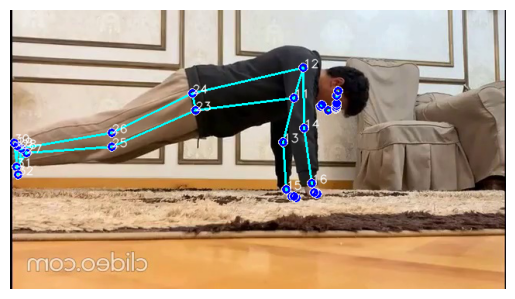

In [82]:
image_path = get_file_path('incorrect', 'up', video_index_corr[0])
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
annotated_image = draw_landmarks_on_image(image, pose_landmarker_result, exclude_numbers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22])
plt.imshow(annotated_image)
plt.axis('off')  # Turn off axis
plt.show()



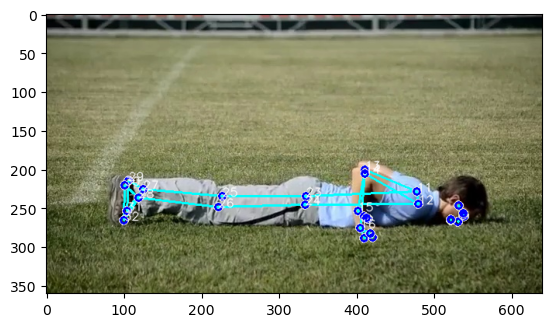

In [ ]:
annotated_image = draw_landmarks_on_image(image.numpy_view(), pose_landmarker_result, exclude_numbers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22])
plt.imshow(annotated_image)
#plt.axis('off')  # Turn off axis
plt.show()

In [63]:
def recenter_landmarks(pose_landmarks, epsilon=0.05):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Get min and max coordinates
    min_coords = np.min(landmarks_array, axis=0)
    max_coords = np.max(landmarks_array, axis=0)

    # Calculate width and height of the bounding box
    box_width, box_height = max_coords - min_coords

    # Scale the landmarks to fit the image, subtracting epsilon to avoid extreme edges
    scale = 1 - 2*epsilon
    scaled_landmarks = ((landmarks_array - min_coords) / np.array([box_width, box_height])) * scale + epsilon

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in scaled_landmarks]

    return new_landmarks



def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Choose a specific landmark to be the center (e.g., landmark #0)
    center_landmark_index = 24

    # Translate the landmarks so that the center landmark is at (0.5, 0.5)
    centered_landmarks = landmarks_array - landmarks_array[center_landmark_index] + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks

In [ ]:
ruleOfThumb = center_landmarks(pose_landmarks)

In [64]:
new_landmarks = center_landmarks(pose_landmarks)

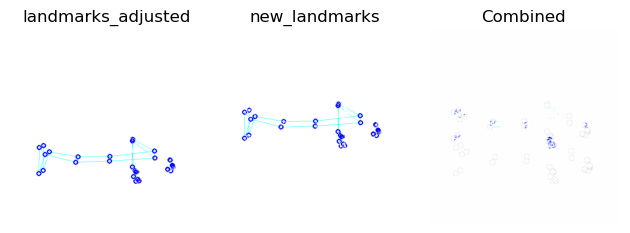

In [65]:
# Display landmarks_adjusted
canvas_adjusted = draw_landmarks_on_blank_canvas(pose_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(1, 3, 1)
plt.imshow(canvas_adjusted)
plt.title('landmarks_adjusted')
plt.axis('off')

# Display new_landmarks
canvas_new = draw_landmarks_on_blank_canvas(new_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(1, 3, 2)
plt.imshow(canvas_new)
plt.title('new_landmarks')
plt.axis('off')

# Display both landmarks_adjusted and new_landmarks on top of each other
canvas_combined = canvas_adjusted + canvas_new  # Add both canvases together
plt.subplot(1, 3, 3)
plt.imshow(canvas_combined)
plt.title('Combined')
plt.axis('off')

plt.tight_layout()
plt.show()


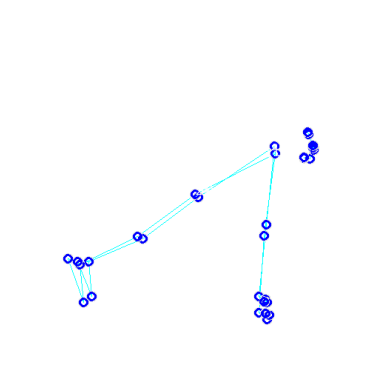

In [58]:
def draw_landmarks_on_blank_canvas(landmarks, image_size=500, circle_radius=10, line_width=2, exclude_numbers=[]):
    # Create a blank canvas
    canvas = np.ones((image_size, image_size, 3), dtype=np.uint8) * 255

    # Create landmark list protobuf from landmarks
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in landmarks
    ])

    # Draw landmarks on the canvas
    mp.solutions.drawing_utils.draw_landmarks(
        canvas,
        pose_landmarks_proto,
        mp.solutions.pose.POSE_CONNECTIONS,
        mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=circle_radius),
        mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 255), thickness=line_width, circle_radius=2)
    )

    # Draw landmark numbers on the canvas.
    for i, landmark in enumerate(landmarks):
        if i not in exclude_numbers:  # only number the landmark if it's not in the exclusion list
            cv2.putText(canvas, str(i), (int(landmark.x * image_size), int((1-landmark.y) * image_size)),
                         cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return canvas

# using this function to draw the landmarks on a blank canvas and display it
canvas = draw_landmarks_on_blank_canvas(new_landmarks, image_size=500, circle_radius=5, line_width=1, exclude_numbers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.imshow(canvas)
plt.axis('off')  # Turn off axis
plt.show()

In [70]:
# connections tuple of the landmarks
connections = mp.solutions.pose.POSE_CONNECTIONS
# Convert the frozenset to a list of tuples
connections = list(connections)

# Convert to a numpy array
connections = np.array(connections, dtype=np.int32)


In [68]:
def rescale_landmarks(landmarks_RuleOfThumb, landmarks_adjusted, connections):
    # Convert landmarks to numpy arrays
    rule_of_thumb_array = np.array([[landmark.x, landmark.y] for landmark in landmarks_RuleOfThumb])
    adjusted_array = np.array([[landmark.x, landmark.y] for landmark in landmarks_adjusted])

    # Compute the length of each segment in both skeletons
    lengths_RuleOfThumb = np.linalg.norm(rule_of_thumb_array[connections[:,0]] - rule_of_thumb_array[connections[:,1]], axis=1)
    lengths_adjusted = np.linalg.norm(adjusted_array[connections[:,0]] - adjusted_array[connections[:,1]], axis=1)

    # Compute the scaling factor for each segment
    scale_factors = lengths_RuleOfThumb / lengths_adjusted

    # Scale the adjusted skeleton by iteratively adjusting each segment length
    for i, (start, end) in enumerate(connections):
        segment = adjusted_array[end] - adjusted_array[start]
        segment = segment * scale_factors[i]
        adjusted_array[end] = adjusted_array[start] + segment

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in adjusted_array]

    return new_landmarks

# let's try to rescale the landmarks

#rescaled_landmarks = rescale_landmarks(ruleOfThumb, new_landmarks, connections)

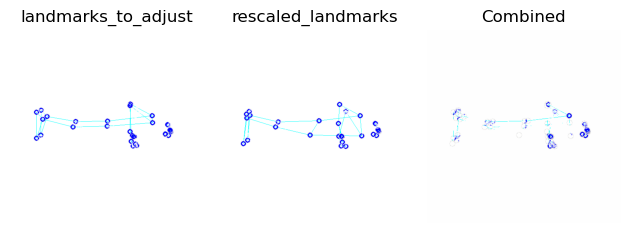

In [71]:
image_path = get_file_path('correct', 'down', video_index_corr[20])
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)
landmarks_to_adjust = center_landmarks(pose_landmarks)

# RoT = rule of thumb
RoT_image_path = get_file_path('correct', 'down', video_index_corr[1])
RoT_pose_landmarks, RoT_pose_landmarker_result = extract_landmarks(RoT_image_path)
RoT_landmarks = center_landmarks(RoT_pose_landmarks)


rescaled_landmarks = rescale_landmarks(RoT_landmarks, new_landmarks, connections)

# Display landmarks_adjusted
canvas_adjusted = draw_landmarks_on_blank_canvas(landmarks_to_adjust, image_size=500, circle_radius=5, line_width=1)
plt.subplot(1, 3, 1)
plt.imshow(canvas_adjusted)
plt.title('landmarks_to_adjust')
plt.axis('off')

# Display new_landmarks
canvas_new = draw_landmarks_on_blank_canvas(rescaled_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(1, 3, 2)
plt.imshow(canvas_new)
plt.title('rescaled_landmarks')
plt.axis('off')

# Display both landmarks_adjusted and new_landmarks on top of each other
canvas_combined = canvas_adjusted + canvas_new  # Add both canvases together
plt.subplot(1, 3, 3)
plt.imshow(canvas_combined)
plt.title('Combined')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def normalize_landmarks(landmarks_rule_of_thumb, landmarks_to_normalize):
    # Connections of landmarks in a pose estimated by MediaPipe
    connections = [(11, 13), (13, 15), (12, 14), (14, 16), (11, 12), 
                   (5, 7), (7, 9), (6, 8), (8, 10), (5, 6), 
                   (5, 11), (6, 12), (11, 23), (12, 24), 
                   (23, 24), (23, 25), (24, 26), (25, 27), 
                   (26, 28), (27, 29), (28, 30), (29, 31), 
                   (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6)]
    normalized_landmarks = landmarks_to_normalize.copy()

    for connection in connections:
        # Calculate the vector of the line segment in landmarks_to_normalize
        vector = landmarks_to_normalize[connection[1]] - landmarks_to_normalize[connection[0]]
        # Calculate the length of the line segment in landmarks_rule_of_thumb
        length = np.linalg.norm(landmarks_rule_of_thumb[connection[1]] - landmarks_rule_of_thumb[connection[0]])
        # Normalize the line segment
        normalized_landmarks[connection[1]] = landmarks_to_normalize[connection[0]] + vector / np.linalg.norm(vector) * length

    return normalized_landmarks


# let's try to normalize the landmarks

np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks])


